In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
PATH = Path('data/pascal/')
list(PATH.iterdir())

FileNotFoundError: [Errno 2] No such file or directory: 'data/pascal'

In [5]:
ls data

data@


In [6]:
train_keys = json.load((PATH/'pascal_train2007.json').open())
train_keys.keys()

FileNotFoundError: [Errno 2] No such file or directory: 'data/pascal/pascal_train2007.json'

In [7]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
train_keys[IMAGES][:5]

NameError: name 'train_keys' is not defined

In [6]:
train_keys[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [7]:
train_keys[CATEGORIES][:3]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'}]

In [8]:
# img = plt.imread(PATH/'VOCdevkit/Images')%
# %ls '{PATH}'/VOCdevkit/VOC2007/JPEGImages


jpegs = list( (PATH/'VOCdevkit/VOC2007/JPEGImages').iterdir());jpegs[:4]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007594.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005682.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001930.jpg')]

data/pascal/VOCdevkit/VOC2007/JPEGImages/006810.jpg


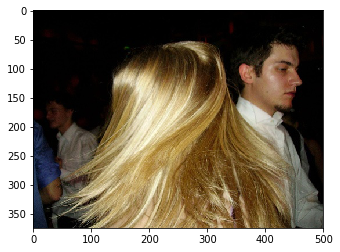

In [9]:
choice = np.random.choice(jpegs)
print(choice)
img = plt.imread(choice)
plt.imshow(img)

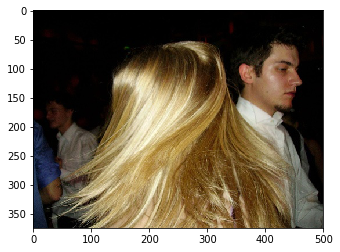

In [10]:
fig, ax = plt.subplots(figsize=None)
ax.imshow(img)


In [11]:
train_keys[ANNOTATIONS][:1]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0}]

# 1.  DATA LOADER

In [12]:
train_annotations = collections.defaultdict(lambda:[])

In [13]:
train_annotations_dict = collections.defaultdict(lambda:[])
for o in train_keys[ANNOTATIONS]: 
    if not o['ignore']:
        image_id = o['image_id']
        bb = o['bbox']
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        train_annotations_dict[image_id].append((bb,o['category_id']))
        
# train_keys[ANNOTATIONS][:1]

In [14]:
train_annotations_dict[12]


[(array([ 96, 155, 269, 350]), 7)]

In [15]:
def get_largest(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [16]:
largest_items = {a: get_largest(b) for a,b in train_annotations_dict.items() }

In [17]:
train_filenames_dict = {o['id']: o['file_name'] for o in train_keys[IMAGES]}; 
# train_filenames = train_keys[IMAGES] 

train_filenames_dict[17]

'000017.jpg'

In [18]:
# train_keys[CATEGORIES][:1]
categories_dict = {o['id']: o['name']for o in train_keys[CATEGORIES]}; categories_dict[1]

'aeroplane'

In [19]:
train_ids = [o['id'] for o in train_keys[IMAGES]]; train_ids[0]

12

In [20]:
IMG_PATH = PATH/'VOCdevkit/VOC2007/JPEGImages'; IMG_PATH

PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')

In [21]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], categories_dict[c], sz=16)

def draw_idx(i):
    im_a = train_annotations_dict[i]
    im = open_image(IMG_PATH/train_filenames_dict[i])
    print(im.shape)
    draw_im(im, im_a)

(375, 500, 3)


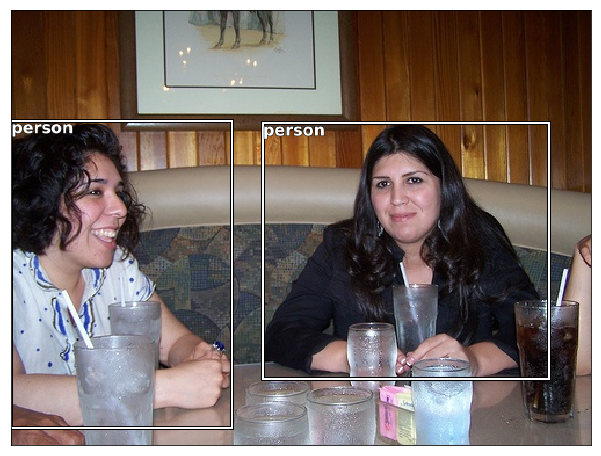

In [22]:
draw_idx(train_ids[7]); 

In [23]:
df = pd.DataFrame({'fn': [train_filenames_dict[o] for o in train_ids ], 
                   'cats': [largest_items[o][1] for o in train_ids]}, 
                  columns=['fn', 'cats'])

In [24]:
df.head()

,fn,cats
0,000012.jpg,7
1,000017.jpg,13
2,000023.jpg,15
3,000026.jpg,7
4,000032.jpg,1


In [25]:
images_folder = 'VOCdevkit/VOC2007/JPEGImages'

In [26]:
filename_category_csv = PATH/'tmp/cat.csv'
os.makedirs(PATH/'tmp',exist_ok=True)
df.to_csv(filename_category_csv, index=False) 

In [27]:
# ImageClassifierData.from_csv??

In [28]:
f_model = resnet34
sz=224
bs=64

In [29]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)

In [30]:
md = ImageClassifierData.from_csv(PATH, images_folder, filename_category_csv, tfms=tfms)

In [31]:
batch = next(iter(md.trn_dl)); batch  

[
 ( 0 , 0 ,.,.) = 
  -1.6795e+00 -1.4832e+00 -1.0331e+00  ...  -6.5108e-01 -9.8102e-02 -4.6371e-01
  -1.7194e+00 -1.5961e+00 -1.1630e+00  ...  -4.1632e-01 -3.0698e-01 -9.1431e-01
  -1.7437e+00 -1.6503e+00 -1.2970e+00  ...  -4.0884e-01 -6.9423e-01 -1.2640e+00
                  ...                   ⋱                   ...                
   6.7358e-01  6.3458e-01  6.8800e-01  ...   1.0719e+00  8.6611e-01  8.6507e-01
   7.4460e-01  7.0980e-01  7.7152e-01  ...   8.5105e-01  8.2448e-01  8.5316e-01
   7.3706e-01  6.9777e-01  7.4496e-01  ...   9.3413e-01  9.2420e-01  8.2843e-01
 
 ( 0 , 1 ,.,.) = 
  -1.4352e+00 -1.3112e+00 -1.0599e+00  ...  -5.9019e-01 -1.3245e-01 -5.3341e-01
  -1.4522e+00 -1.3954e+00 -1.1432e+00  ...  -4.2258e-01 -3.3082e-01 -8.9832e-01
  -1.4737e+00 -1.4314e+00 -1.2081e+00  ...  -4.8281e-01 -7.3156e-01 -1.1864e+00
                  ...                   ⋱                   ...                
   2.1896e-01  1.8527e-01  2.1872e-01  ...   6.7879e-01  4.8373e-01  4.6063e-01


In [32]:
learn = ConvLearner.pretrained??

In [ ]:
learn = ConvLearner.pretrained

In [33]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 30946492.02it/s]


In [34]:
learn.opt_fn = optim.Adam

In [35]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                 
    0      1.165092   0.619735   0.808293  
    1      0.826512   0.683543   0.805889                  
    2      0.661549   0.646806   0.811899                  



[0.6468062, 0.8118990361690521]

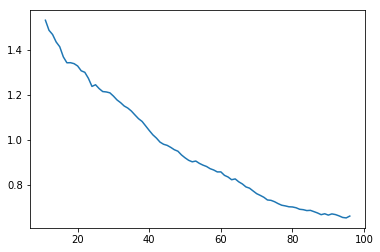

In [36]:
learn.sched.plot_loss()